In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,r2_score
from sklearn.model_selection import cross_val_score

In [22]:
print(pd.__version__)
print(sklearn.__version__)

2.3.3
1.8.0


In [2]:
# Loading and Understanding Data

df = pd.read_csv('Titanic-Dataset.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df.shape

(891, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Dropping unecessary features

df.drop(columns=['PassengerId','Name','Ticket','Cabin'],inplace=True)
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [6]:
#column transformation and dimentionality reduction

def family_size_category(sibsp, parch):
    family_size = sibsp + parch + 1
    
    if family_size == 1:
        return 1   # Alone
    elif family_size == 2:
        return 2   # Couple
    elif 3 <= family_size <= 4:
        return 3   # Small family
    else:
        return 4   # Large family

df['family_size_group'] = df.apply(
    lambda x: family_size_category(x['SibSp'], x['Parch']),
    axis=1
)
df.drop(columns=['SibSp','Parch'],inplace=True)
df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,family_size_group
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1


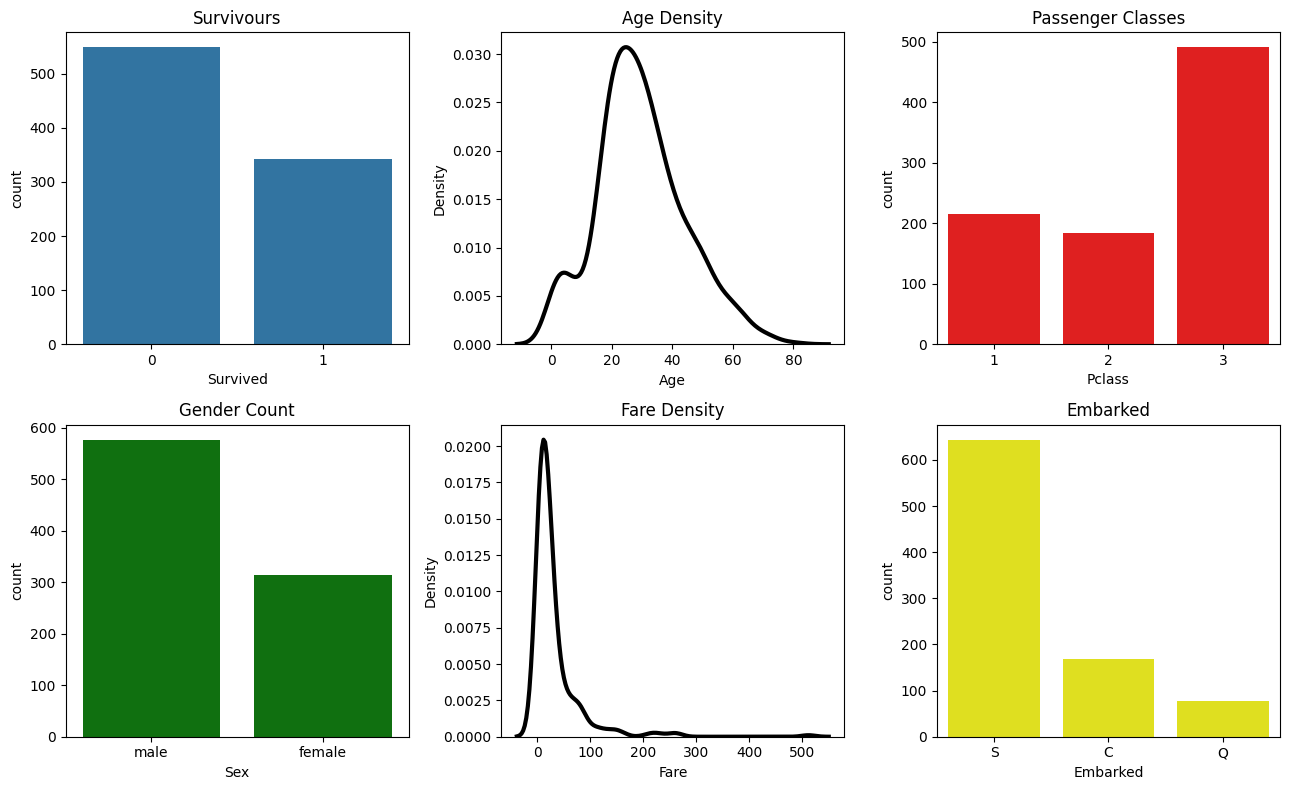

In [7]:
# Exploratory Data Analysis (Univariate)

fig, axes = plt.subplots(2,3 ,figsize=(13,8))
sns.countplot(x='Survived', data=df, ax=axes[0,0])
axes[0,0].set_title('Survivours')
sns.kdeplot(x='Age', data=df, ax=axes[0,1],linewidth=3, color='black')
axes[0,1].set_title('Age Density')
sns.countplot(x='Pclass', data=df, ax=axes[0,2], color='red')
axes[0,2].set_title('Passenger Classes')
sns.countplot(x='Sex', data=df, ax=axes[1,0], color='green')
axes[1,0].set_title('Gender Count')
sns.kdeplot(x='Fare', data=df, ax=axes[1,1],linewidth=3, color='black')
axes[1,1].set_title('Fare Density')
sns.countplot(x='Embarked', data=df, ax=axes[1,2],color='yellow')
axes[1,2].set_title('Embarked')

plt.tight_layout()
plt.show()

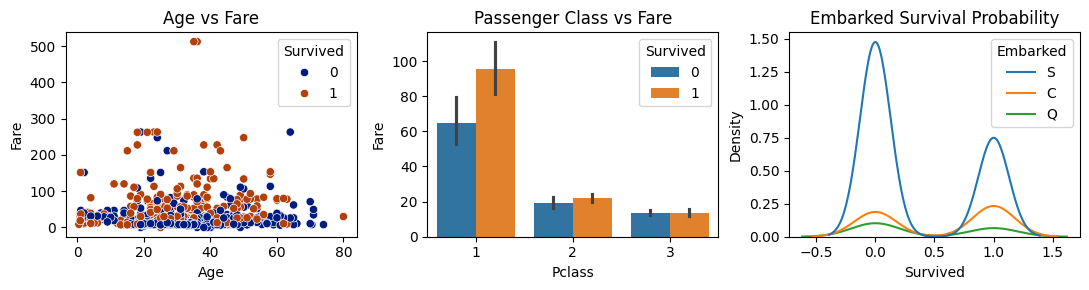

In [8]:
# Exploratory Data Analysis (Multivariate)

fig, axes = plt.subplots(1,3 ,figsize=(11,3))
sns.scatterplot(x='Age', y='Fare',data=df, ax=axes[0], hue='Survived', palette='dark')
axes[0].set_title('Age vs Fare')
sns.barplot(x='Pclass',y='Fare',data=df,hue='Survived',ax=axes[1])
axes[1].set_title('Passenger Class vs Fare')
sns.kdeplot(x='Survived', data=df, hue='Embarked',ax=axes[2])
axes[2].set_title('Embarked Survival Probability')

plt.tight_layout()
plt.show()

In [9]:
# Train - Test - Split

X_train,X_test,y_train,y_test = train_test_split(
    df.drop(columns=['Survived']),
    df['Survived'],
    test_size=0.2,random_state=42
)

In [10]:
num_cols = ['Age','Fare']
cat_cols = ['Sex','Embarked']

In [11]:
# Creating Pipeline using Column Transformers

preprocess = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(
            SimpleImputer(strategy='mean'),
            StandardScaler()
        ), num_cols),

        ('cat', make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first',handle_unknown='ignore')
        ), cat_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipe = make_pipeline(
    preprocess,
    DecisionTreeClassifier(random_state=42)
)

In [12]:
# Model Training

pipe.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

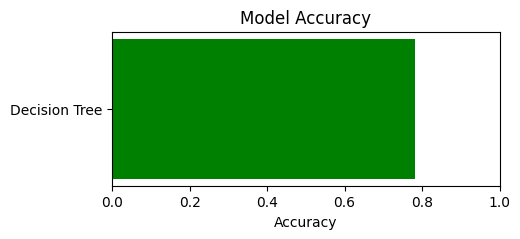

In [13]:
# Prediction and Accuracy Plotting

y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,2))
ax.barh(['Decision Tree'], [accuracy], color='green')
ax.set_xlim(0,1)
ax.set_xlabel('Accuracy')
ax.set_title('Model Accuracy')
plt.show()

In [15]:
import pickle

with open('titanic_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)